## Time domain simulations of two cavity modes coupled to a single mechanical mode 

In [46]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from numpy import *
from qutip import *
from IPython.display import Image
from numpy.linalg import *
import multiprocessing  
from multiprocessing import Pool, cpu_count
import scipy.constants as sc
import time
import datetime
import os
from matplotlib import cm
import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})
plt.rcParams['axes.linewidth'] = 1.5 #set the value globally
plt.rcParams['figure.dpi'] = 100

saveResults = True

### Single processor test script

In [60]:
N = 3

##### Cavity A ######

wa = 2 * pi * 4.0 * 1e9


E_a = 2 * pi * 80 * 1e3    

kappa_a = 2 * pi * 100 * 1e3  

T_a = 0
w_th_a = (sc.k*T_a)/(sc.hbar)
n_th_a = n_thermal(wa, w_th_a)

###### Cavity B #####

wb = 2 * pi * 4.1 * 1e9


E_b = 2 * pi * 80 * 1e3   

kappa_b = 2 * pi * 100 * 1e3

T_b = 0
w_th_b = (sc.k*T_b)/(sc.hbar)
n_th_b = n_thermal(wb, w_th_b)


##### Qubit #####

#wq = 2 * pi * 3.0 * 1e9

#Ga = 2 * pi * 200 * 1e6
#Gb = 2 * pi * 100 * 1e6

#kappa_q = 2 * pi * 100 * 1e3

#T_q = 0.09
#w_th_q = (sc.k*T_q)/(sc.hbar)
#n_th_q = n_thermal(wq, w_th_q)

##### Mechanical Resonator #####

wr = 2 * pi * 1.0 * 1e9

ga = 2 * pi * 15 * 1e6
gb = 2 * pi * 15 * 1e6

etaA = ((ga**2)/wr)
etaB = ((gb**2)/wr)
etaAB = ((gb*ga)/wr)

Ohm_a = wa - etaA 
Ohm_b = wb - etaB

gamma = 10 * kappa_a  

T_r = 0.01
w_th_r = (sc.k*T_r)/(sc.hbar)
n_th_r = n_thermal(wr, w_th_r)


############################
(n_th_a, n_th_b, n_th_r)

(0.0, 0.0, 0.008304373364239451)

In [61]:
# Operator definitions
a = tensor(destroy(N), qeye(N), qeye(N))
b = tensor(qeye(N), destroy(N), qeye(N))
r = tensor(qeye(N), qeye(N), destroy(N))
#sm = tensor(qeye(N), qeye(N), destroy(2), qeye(N))
#sz = tensor(qeye(N), qeye(N), sigmaz(), qeye(N))
#sx = tensor(qeye(N), qeye(N), sigmax(), qeye(N))
I = tensor(qeye(N), qeye(N), qeye(N))

Na = a.dag() * a
Nb = b.dag() * b
#Nq = sm.dag() * sm
Nr = r.dag() * r
Xa = a.dag() + a
Xb = b.dag() + b
#Xq = sm.dag() + sm
Xr = r.dag() + r

In [62]:
etaA = ((ga**2)/wr)
etaB = ((gb**2)/wr)
etaAB = ((gb*ga)/wr)
etaA/(2*pi*1e3),etaB/(2*pi*1e3),etaAB/(2*pi*1e3)

(225.0, 225.0, 225.0)

In [63]:
tau_a = (kappa_a/(2*pi))**-1
tau_b = (kappa_b/(2*pi))**-1
tau_a, tau_b

(9.999999999999999e-06, 9.999999999999999e-06)

In [64]:
t0 = 0
t1 = 5 * tau_a
#t2 = 5 * tau_a + 5 * tau_b
tf = 5 * tau_a + 5 * tau_b

tlist = linspace(t0,tf,200)

In [65]:
Ha = (wa-Ohm_a) * Na
Hb = (wb-Ohm_b) * Nb
Hr = wr * Nr
Hint_a = -ga * Na * Xr
Hint_b = -gb * Nb * Xr
Hdrive_a = E_a * Xa
Hdrive_b = Xb
#Hq = 0.5 * (wq) * sz
#Hqa = Ga * (a * sm.dag() + a.dag() * sm)
#Hqb = Gb * (b * sm.dag() + b.dag() * sm)
#Hqa = (Ga**2/(wq-wa)) * Na * sz 
#Hqb = (Gb**2/(wq-wb)) * Nb * sz 

def Hdrive_b_coeff(t, args):
    return E_b * (1-heaviside(t-t1,1))

H0 = Ha + Hb + Hr + Hint_a + Hint_b + Hdrive_a #+ Hdrive_b #+ Hq + Hqa + Hqb

H = [H0,[Hdrive_b,Hdrive_b_coeff]]



In [66]:
# collapse operators
c_ops = []

# Relaxations, temperature = 0 or >0

# cavity-a relaxation
rate = kappa_a * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(sqrt(rate) * a)
    
# cavity-b relaxation
rate = kappa_b * (1 + n_th_b)
if rate > 0.0:
    c_ops.append(sqrt(rate) * b)
    
# mechanical oscillator relaxation
rate = gamma * (1 + n_th_r)
if rate > 0.0:
    c_ops.append(sqrt(rate) * r)
    
# Excitations, only temperature > 0  

rate = kappa_a * n_th_a
if rate > 0.0:
    c_ops.append(sqrt(rate) * a.dag())

rate = kappa_b * n_th_b
if rate > 0.0:
    c_ops.append(sqrt(rate) * b.dag())

# mechanical oscillator excitation    
rate = gamma * n_th_r
if rate > 0.0:
    c_ops.append(sqrt(rate) * r.dag())

In [67]:
rho0 = tensor(coherent_dm(N,0),coherent_dm(N,0),coherent_dm(N,0))
rho0

Quantum object: dims = [[3, 3, 3], [3, 3, 3]], shape = (27, 27), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [68]:
sol = mesolve(H,rho0,tlist,c_ops,[],options=Odeoptions(nsteps=1e6))

In [70]:
rho_ss_f = sol.states[-1]

In [71]:
rho_ss_1 = sol.states[98]

In [72]:
rhoA = ptrace(rho_ss_1,(0))
rhoB = ptrace(rho_ss_1,(1))
rhoR = ptrace(rho_ss_1,(2))

rhoA_f = ptrace(rho_ss_f,(0))
rhoB_f = ptrace(rho_ss_f,(1))
rhoR_f = ptrace(rho_ss_f,(2))

In [73]:
chi_matrix_1 = rho_ss_1 - tensor(rhoA, rhoB, rhoR)
chi_matrix_f = rho_ss_f - tensor(rhoA_f, rhoB_f, rhoR_f)

In [74]:
chi_matrix_1

Quantum object: dims = [[3, 3, 3], [3, 3, 3]], shape = (27, 27), type = oper, isherm = True
Qobj data =
[[-4.61211909e-02+0.00000000e+00j -4.41926436e-03+2.55107072e-06j
  -5.46576877e-05+4.68498794e-08j -1.87194065e-02+2.71426573e-02j
   7.04633486e-04+1.18419822e-03j  5.33781042e-06+1.08630606e-05j
  -3.87402968e-03+6.91402859e-03j  1.44155391e-04+7.81154574e-04j
   3.94708514e-06+1.84995066e-05j -1.87194065e-02+2.71426573e-02j
   7.04633486e-04+1.18419822e-03j  5.33781042e-06+1.08630606e-05j
  -3.25222155e-03-1.78391819e-02j  2.32962243e-04+8.49029354e-04j
   6.07178069e-06+2.26731135e-05j  2.38062547e-03-4.40488377e-03j
   1.73667776e-05+1.64195119e-04j  1.63155598e-07+6.81135456e-06j
  -3.87402968e-03+6.91402859e-03j  1.44155391e-04+7.81154574e-04j
   3.94708514e-06+1.84995066e-05j  2.38062547e-03-4.40488377e-03j
   1.73667776e-05+1.64195119e-04j  1.63155598e-07+6.81135456e-06j
   9.64509548e-04-7.49947502e-04j  4.06483352e-06+1.63455211e-05j
  -8.58330458e-08+9.87857614e-07j]
 [-

In [75]:
chi_matrix_f

Quantum object: dims = [[3, 3, 3], [3, 3, 3]], shape = (27, 27), type = oper, isherm = True
Qobj data =
[[ 6.01698979e-05+0.00000000e+00j -3.83153596e-03+2.23294197e-06j
  -4.43022337e-05-5.63023891e-09j -1.17563777e-11+1.03875410e-11j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  3.09639088e-05+2.93207470e-05j
   9.78863510e-04+2.10562495e-03j  9.60472943e-06+2.05624997e-05j
   9.19067045e-12+9.37886233e-12j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   8.66255283e-06+1.41363648e-05j  3.13251020e-06+1.43838281e-03j
   1.00945135e-07+3.47075206e-05j  2.07850868e-12+2.60324508e-12j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [-

In [76]:
test_1 = etaAB * (chi_matrix_1*Na*Nb).tr()
test_f = etaAB * (chi_matrix_f*Na*Nb).tr()
test_1/(2*pi*1e3),test_f/(2*pi*1e3)

(-11.777553655016188, 1.418393611236302e-13)

In [77]:
negativity

<function qutip.entropy.negativity(rho, subsys, method='tracenorm', logarithmic=False)>

In [78]:
Na_avg_1 = expect(Na,rho_ss_1)
Na2_avg_1 = expect(Na*Na,rho_ss_1)
Na_avg_f = expect(Na,rho_ss_f)
Na2_avg_f = expect(Na*Na,rho_ss_f)
Na_avg_1,Na_avg_f,Na2_avg_1,Na2_avg_f

(0.27867028096996166,
 0.46922254915669315,
 0.30242769499653954,
 0.5148847573678519)

In [79]:
Nb_avg_1 = expect(Nb,rho_ss_1)
Nb_avg_f = expect(Nb,rho_ss_f)
Nb_avg_1,Nb_avg_f

(0.27867028096996166, 6.328881246774071e-15)

In [80]:
rhoAB_1 = ptrace(rho_ss_1,(0,1))
rhoAB_f = ptrace(rho_ss_f,(0,1))
neg_1 = negativity(rhoAB_1, 0, method='eigenvalues', logarithmic=False)
neg_f = negativity(rhoAB_f, 0, method='eigenvalues' )
neg_1,neg_f

(0.09508843754539315, 2.504373235123454e-12)

In [81]:
rhoABf = ptrace(rho_ss_f,(0,1))
neg_f = negativity(rhoABf, 0, method='eigenvalues')
neg_f

2.504373235123454e-12

In [82]:
(etaAB * Na_avg_1 * Nb_avg_1) /(2*pi*1e3)

17.47285323657241

In [83]:
deltaE_1 = - etaA * Na2_avg_1 - etaAB * Na_avg_1 * Nb_avg_1 - test_1
deltaE_1/(2*pi*1e3)

-73.74153095577762

In [84]:
etaAB * Na_avg_f * Nb_avg_f

4.198249141382291e-09

In [85]:
deltaE_f = - etaA * Na2_avg_f - etaAB * Na_avg_f * Nb_avg_f - test_1
deltaE_f/(2*pi*1e3)

-104.07151675275117

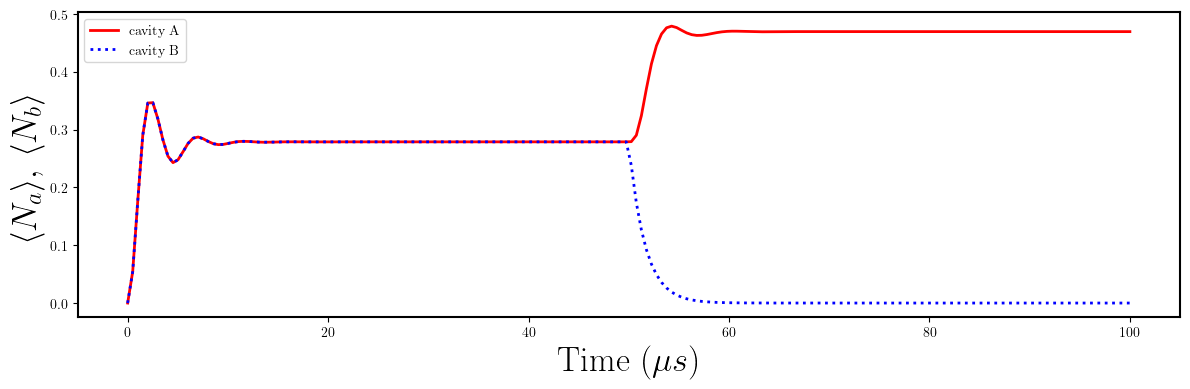

In [86]:
Na_list = expect(Na, sol.states)
Nb_list = expect(Nb, sol.states)

fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12,4))

axes.plot(tlist*(1e6), Na_list, 'r', linewidth=2, label="cavity A")
axes.plot(tlist*(1e6), Nb_list, 'b:', linewidth=2, label="cavity B")

axes.set_ylabel(r"$\langle N_a \rangle,\,\langle N_b\rangle$", fontsize=25)
axes.set_xlabel("Time ($\mu s$)", fontsize=25)
axes.legend()

fig.tight_layout()

In [87]:
tlist2 = linspace(t0,t1,10000)
corr_vec = correlation_2op_2t(H, rho0, None, tlist2, [], a.dag(), a)

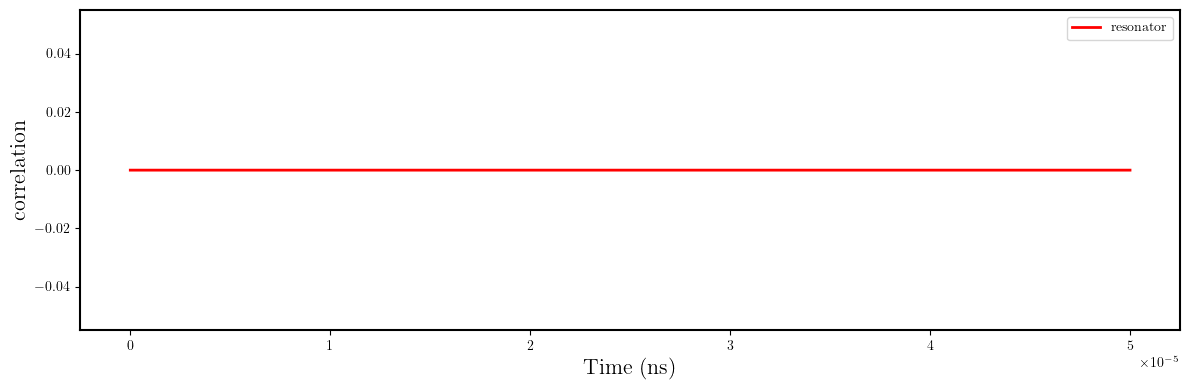

In [88]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,4))

ax.plot(tlist2, real(corr_vec), 'r', linewidth=2, label="resonator")
ax.set_ylabel("correlation", fontsize=16)
ax.set_xlabel("Time (ns)", fontsize=16)
ax.legend()

fig.tight_layout()

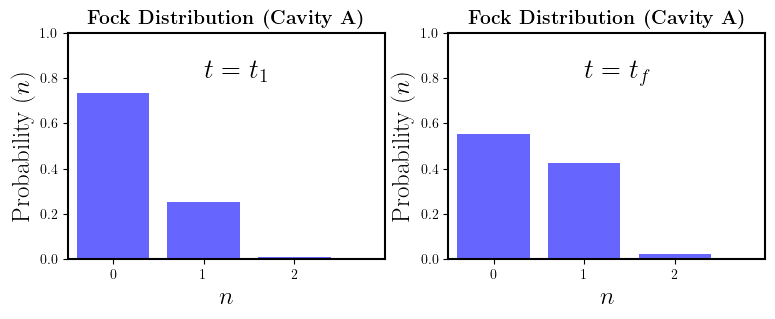

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(9,3))

axes[0].bar(arange(0, N), real(rhoA.diag()), label='Cavity A' ,color="blue", alpha=0.6)
axes[0].set_title("\\textbf{Fock Distribution (Cavity A)}",fontsize=14)
axes[0].set_ylim(0, 1)
axes[0].set_xlim(-0.5, N)
axes[0].set_xticks(arange(0, N))
axes[0].set_xlabel(r'$n$', fontsize=18)
axes[0].set_ylabel(r'Probability ($n$)', fontsize=18)
axes[0].text(1, 0.8, r"$t = t_1$", color='black', fontsize=20)

axes[1].bar(arange(0, N), real(rhoA_f.diag()), color="blue", alpha=0.6)
axes[1].set_title(r"\textbf{Fock Distribution (Cavity A)}",fontsize=14)
axes[1].set_ylim(0, 1)
axes[1].set_xlim(-0.5, N)
axes[1].set_xticks(arange(0, N))
axes[1].set_xlabel(r'$n$', fontsize=18)
axes[1].set_ylabel(r'Probability ($n$)', fontsize=18)
axes[1].text(1, 0.8, r"$t = t_f$", color='black', fontsize=20)

plt.show()

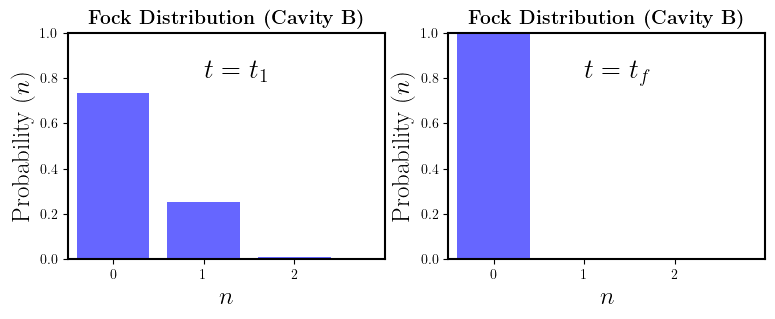

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(9,3))

axes[0].bar(arange(0, N), real(rhoB.diag()), color="blue", alpha=0.6)
axes[0].set_title("\\textbf{Fock Distribution (Cavity B)}",fontsize=14)
axes[0].set_ylim(0, 1)
axes[0].set_xlim(-0.5, N)
axes[0].set_xticks(arange(0, N))
axes[0].set_xlabel(r'$n$', fontsize=18)
axes[0].set_ylabel(r'Probability ($n$)', fontsize=18)
axes[0].text(1, 0.8, r"$t = t_1$", color='black', fontsize=20)

axes[1].bar(arange(0, N), real(rhoB_f.diag()), color="blue", alpha=0.6)
axes[1].set_title("\\textbf{Fock Distribution (Cavity B)}",fontsize=14)
axes[1].set_ylim(0, 1)
axes[1].set_xlim(-0.5, N)
axes[1].set_xticks(arange(0, N))
axes[1].set_xlabel(r'$n$', fontsize=18)
axes[1].set_ylabel(r'Probability ($n$)', fontsize=18)
axes[1].text(1, 0.8, r"$t = t_f$", color='black', fontsize=20)

plt.show()

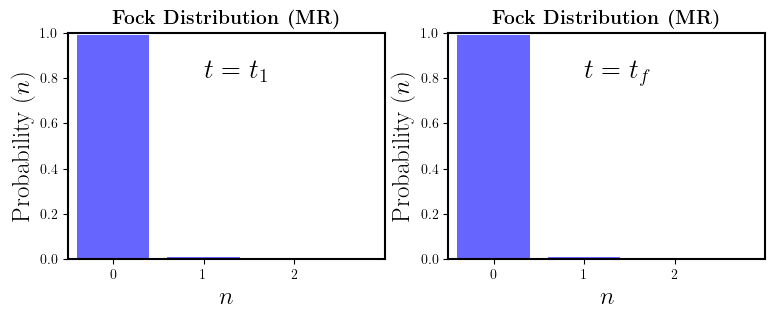

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(9,3))

axes[0].bar(arange(0, N), real(rhoR.diag()), color="blue", alpha=0.6)
axes[0].set_title("\\textbf{Fock Distribution (MR)}",fontsize=14)
axes[0].set_ylim(0, 1)
axes[0].set_xlim(-0.5, N)
axes[0].set_xticks(arange(0, N))
axes[0].set_xlabel(r'$n$', fontsize=18)
axes[0].set_ylabel(r'Probability ($n$)', fontsize=18)
axes[0].text(1, 0.8, r"$t = t_1$", color='black', fontsize=20)

axes[1].bar(arange(0, N), real(rhoR_f.diag()), color="blue", alpha=0.6)
axes[1].set_title("\\textbf{Fock Distribution (MR)}",fontsize=14)
axes[1].set_ylim(0, 1)
axes[1].set_xlim(-0.5, N)
axes[1].set_xticks(arange(0, N))
axes[1].set_xlabel(r'$n$', fontsize=18)
axes[1].set_ylabel(r'Probability ($n$)', fontsize=18)
axes[1].text(1, 0.8, r"$t = t_f$", color='black', fontsize=20)

plt.show()

In [13]:
etaAB/(2*pi*1e3)

225.0

In [10]:
linspace(5,40,36)

array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17.,
       18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30.,
       31., 32., 33., 34., 35., 36., 37., 38., 39., 40.])

### Multiprocessing script

In [47]:
cpu_count()

80

In [39]:
# Script to determine the number of max number of workers (cpu0 that the code can use
from concurrent.futures import ProcessPoolExecutor

def f(x):
    return x

if __name__ == '__main__':
    with ProcessPoolExecutor(max_workers=70) as executor:
        a = list(executor.map(f, range(70)))
        print(a)

ValueError: max_workers must be <= 61

In [94]:
N = 3

# Frequencies: wa, wb, wr
w = 2 * pi * array([4.0, 4.1, 1.0]) * 1e9

# Coupling strength: ga, gb (= ga)  
g0 = 10
gf = 20
g_size = 3
galist = 2* pi * array([10,20,40]) * 1e6

etaA_list = galist**2/wr 
etaAB_list = galist**2/wr # When ga = gb

# Drive frequnecies: Omega_a
Omega_a_initial = w[0] - 3 * (etaA_list[0] +  2 * etaAB_list[0])
Omega_a_final = w[0] + 1 * (etaA_list[0] +  2 * etaAB_list[0])

Omega_a_list = linspace(Omega_a_initial, Omega_a_final, 60)

# Drive amplitude: Ea, Eb
E_drive = 2 * pi * array([80, 80]) * 1e3


# Dissipation rates: kappa_a, kappa_b, gamma
kappa = 2 * pi * array([50, 50, 500]) * 1e3 

# Temperatures: Ta, Tb, Tr
T = array([0, 0, 0.01])


In [93]:
etaA_list = galist**2/wr 
etaAB_list = galist**2/wr # When ga = gb

etaA_list/(2 * pi * 1e3), etaAB_list/(2 * pi * 1e3)

(array([ 100.,  400., 1600.]), array([ 100.,  400., 1600.]))

In [95]:
from Solver import Solver_TwoModesCoupledToMR_timeDomain

if __name__ == '__main__':
    pool = Pool(60)
    procs = Omega_a_list
    aresults = [pool.apply_async(Solver_TwoModesCoupledToMR_timeDomain, args=(N,
                                                                              w,
                                                                              galist,
                                                                              E_drive,
                                                                              kappa,
                                                                              T,
                                                                              proc)) for proc in procs]
    
    pool.close()
    pool.join()
        
    results = [ar.get() for ar in aresults]


ValueError: max_workers must be <= 61

In [99]:
len(results)

60

In [100]:
results[0]

[[0.11110025122235881, 0.18010465556520658, 0.11295074400281428],
 [0.057802945375629106, 0.1259447838301187, 0.6395186447928027],
 [0.05780294450559864, 0.1259448173321395, 0.6395191647798617],
 [0.06287439017750787, 0.1401588983324779, 0.6436988478749284],
 [0.06287438930666223, 0.14015893198522336, 0.6436993678856974],
 [0.43046430420563625, 0.09612430477896246, 0.02375953022301303],
 [0.10020123520263784, 0.18079757780214162, 0.11196642352501604],
 [0.07465803688989678, 0.15771419677571574, 0.6279038189765339],
 [0.07465803676643891, 0.15771422533657106, 0.627904334251846],
 [0.07465803688989678, 0.15771419676064327, 0.6279038189856911],
 [0.07465803676643891, 0.1577142253214986, 0.6279043342610032],
 [4.8852737205932125e-08, 4.661136839934891e-10, 2.4363766771330866e-09],
 [29571.307378401045, 50052.64601621754, 18109.430656073666],
 [0.0, 0.00012176251347236442, 7.305037958437629e-05],
 [-29206.537392334405, 50010.91356753756, -18034.99106815088],
 [0.0, -1.837231112324332e-05, -

In [97]:
name = "Simulation_Time_Domain"

time_index = datetime.datetime.now().strftime("_[%Y-%m-%d]_[%Hh%Mm]")
date_index = datetime.datetime.now().strftime("_[%Y-%m-%d]")

save_path = "Results/" + name + "/"
if(saveResults == True):
    try:
        os.mkdir("Results/" + name)
    except OSError:
        print ("Creation of the directory %s failed. Directory may already exist." % save_path)

x_list = [(w[0]-k) / (2*pi*1e6) for k in Omega_a_list]
y_list = [k / (2*pi*1e6) for k in galist]
z_list = transpose(results,(1,2,0))

x_list_list = []

for i in range(len(galist)):
    etaA = etaA_list[i]
    etaAB = etaAB_list[i]
    x_list_2 = [(w[0]-k) / (etaA+etaAB) for k in Omega_a_list]
    x_list_list.append(x_list_2)

if(saveResults == True):
    save(save_path + "Results" + time_index, (x_list , y_list, z_list))
    save(save_path + "Results_2" + time_index , (x_list_2 , y_list, z_list))

Creation of the directory Results/Simulation_Time_Domain/ failed. Directory may already exist.


ValueError: axes don't match array

IndexError: index 15 is out of bounds for axis 0 with size 5

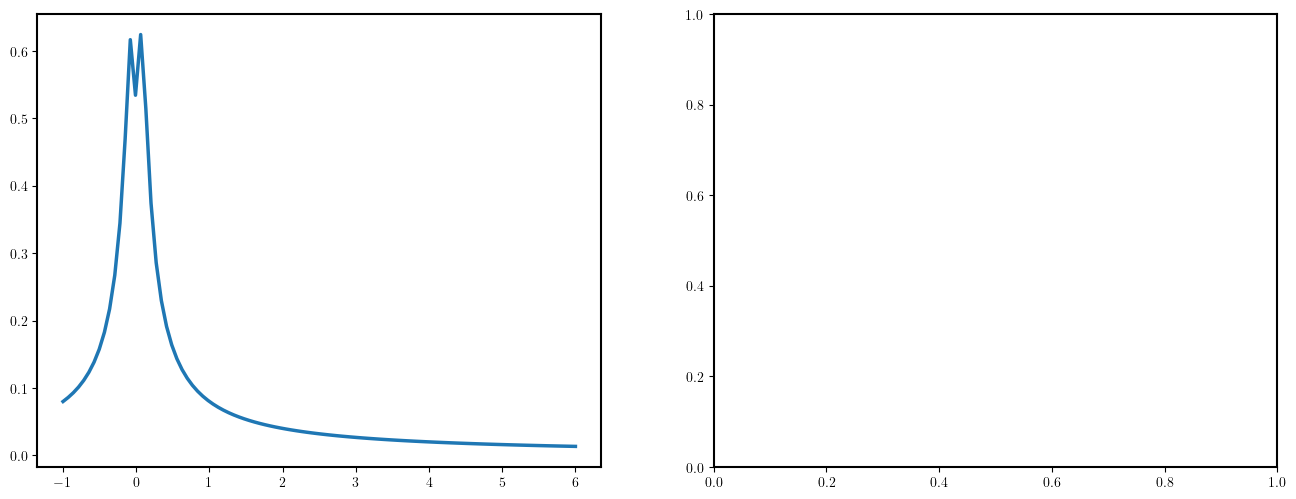

In [13]:
###############################
ls = 30.0       # Label size
fs = 30.0       # Font size
lw = 2.5        # Line width
wr = 2 * pi * 1e6 * 1000  # Mechanical Frequency
###############################
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i in [0,15,30]:
    axes[0].plot(x_list, abs(z_list[0][i]), linestyle='-', label=r'$g_1/2\pi = $ %.1f MHz ($g_1/\omega_r = $ %.2f)' % (y_list[i],(2 * pi * 1e6 * y_list[i]/(wr))), lw = lw)

axes[0].set_xlabel(r'$(\omega_1 - \Omega_1)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes[0].set_ylabel(r'$\vert\langle \hat{a}_1\rangle\vert$ from QuTiP', rotation=90, fontsize=fs)

axes[0].tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes[0].tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes[0].yaxis.set_ticks_position('both')
axes[0].legend(loc=2, fontsize=floor(fs/2), frameon=False)

#axes[0].set_xlim(-6,2)
#axes[0].set_ylim(-0.02,1)

start, end = axes[0].get_xlim()
axes[0].xaxis.set_ticks(arange(start, end+1, 2))

axes[0].xaxis.set_ticks_position('both')
axes[0].yaxis.set_ticks_position('both')

axes[0].yaxis.set_minor_locator(AutoMinorLocator(2))
axes[0].xaxis.set_minor_locator(AutoMinorLocator(4))

axes[0].xaxis.set_tick_params(length=5)
axes[0].yaxis.set_tick_params(length=5)

axes[0].margins(x=0.1, y=0.1)
###############################
for i in [0,15,30]:
    axes[1].plot(x_list, abs(z_list[1][i]), linestyle='-', label=r'$g_1/2\pi = $ %.1f MHz ($g_1/\omega_r = $ %.2f)' % (y_list[i],(2 * pi * 1e6 * y_list[i]/(wr))), lw = lw)

axes[1].set_xlabel(r'$(\omega_1 - \Omega_1)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes[1].set_ylabel(r'$\vert\langle \hat{a}_1\rangle\vert$ from Eq.(20)', rotation=90, fontsize=fs)

axes[1].tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes[1].tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes[1].yaxis.set_ticks_position('both')
axes[1].legend(loc=2, fontsize=floor(fs/2), frameon=False)

#axes[1].set_xlim(-6,2)
#axes[1].set_ylim(-0.02,1)

start, end = axes[1].get_xlim()
axes[1].xaxis.set_ticks(arange(start, end+1, 2))

axes[1].xaxis.set_ticks_position('both')
axes[1].yaxis.set_ticks_position('both')

axes[1].yaxis.set_minor_locator(AutoMinorLocator(2))
axes[1].xaxis.set_minor_locator(AutoMinorLocator(4))

axes[1].xaxis.set_tick_params(length=5)
axes[1].yaxis.set_tick_params(length=5)

axes[1].margins(x=0.01, y=0.01)
###############################
#axes[0].text(-7.5, 1, r"$\mathbf{a}$", color='black', fontsize=50)
#axes[1].text(-7.5, 1, r"$\mathbf{b}$", color='black', fontsize=50)
###############################
plt.tight_layout()

if(saveResults == True):
    filename = "001"
    plt.savefig(save_path + "Figures/" + filename + time_index + ".pdf", bbox_inches='tight')
    plt.savefig(save_path + "Figures/" + filename + time_index + ".png", bbox_inches='tight')

plt.show()


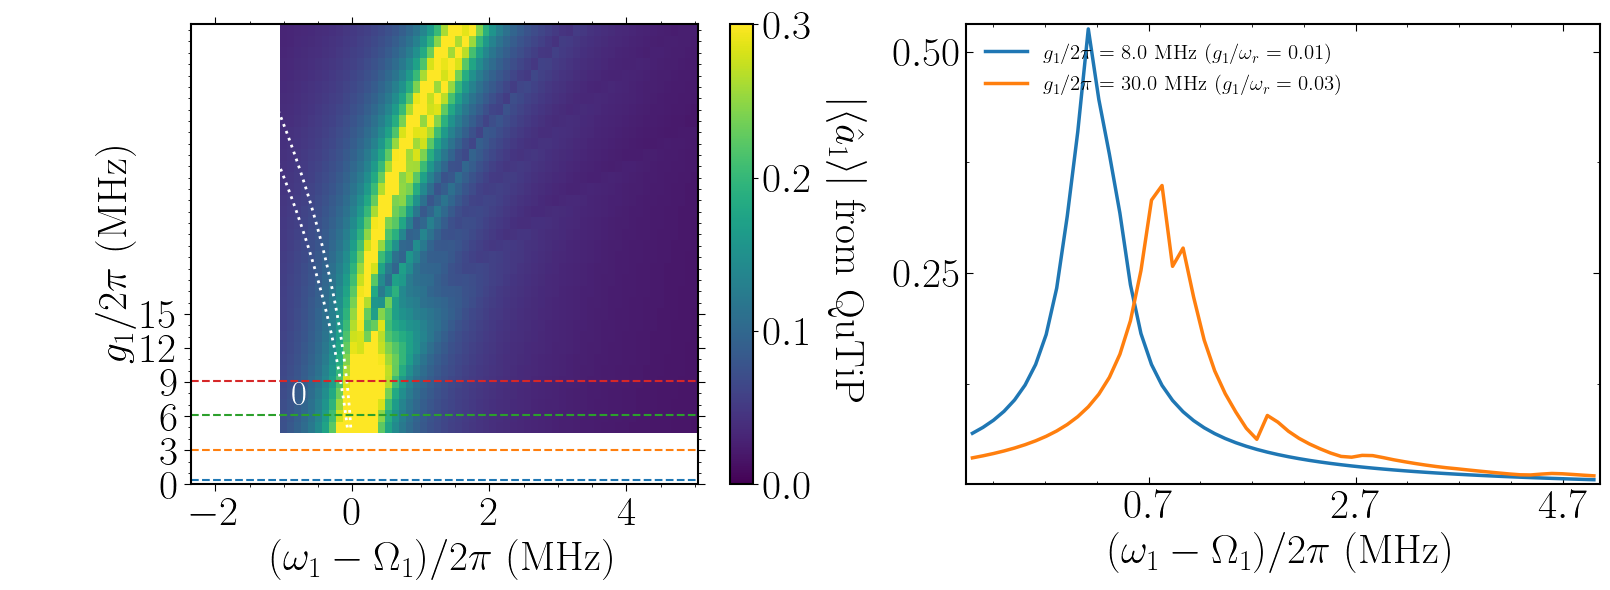

In [36]:
###############################
ls = 30.0       # Label size
fs = 30.0       # Font size
lw = 2.5        # Line width
wr = 2 * pi * 1e6 * 1000  # Mechanical Frequency
###############################
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

nrm = mpl.colors.Normalize(0, 0.3)
im1 = axes[0].pcolormesh(x_list, y_list, abs(z_list[0]), cmap=cm.viridis, norm=nrm, shading='auto')
###############################
shift_n0 = [-(2 * pi * 1e6 * k**2)/(wr) for k in y_list]
shift_n1 = [(-(2 * pi * 1e6 * k**2)/(wr))-((2 * pi * 1e6 * 2*k*5)/(wr)) for k in y_list]
axes[0].plot(shift_n0, y_list, ':', color='white', lw=2)
axes[0].plot(shift_n1, y_list, ':', color='white', lw=2)
axes[0].text(-5, 4, r"$n_2 = 1$", color='white', fontsize=25)
axes[0].text(-2, 7, r"$n_2 = 0$", color='white', fontsize=25)
###############################
axes[0].set_xlabel(r'$(\omega_1 - \Omega_1)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes[0].set_ylabel(r'$g_1/2\pi$ (MHz)', rotation=90, fontsize=fs)
axes[0].tick_params(axis='both', which='major', direction='out', labelsize=ls)
axes[0].tick_params(axis='both', which='minor', labelsize=ls)
axes[0].yaxis.set_ticks(arange(0, 15.1, 3))
axes[0].yaxis.set_ticks_position('both')
axes[0].xaxis.set_ticks_position('both')
###############################
axes[0].axhline(y = 0.4, color = 'C0', linestyle = '--')
axes[0].axhline(y = 3.0, color = 'C1', linestyle = '--')
axes[0].axhline(y = 6.1, color = 'C2', linestyle = '--')
axes[0].axhline(y = 9.1, color = 'C3', linestyle = '--')
###############################
axes[0].yaxis.set_minor_locator(AutoMinorLocator(3))
axes[0].xaxis.set_minor_locator(AutoMinorLocator(4))

axes[0].xaxis.set_tick_params(length=5)
axes[0].yaxis.set_tick_params(length=5)

#axes[0].set_xlim(-6, 2)
#axes[0].set_ylim(0, 12)

cbar = plt.colorbar(im1, ax=axes[0])
cbar.ax.tick_params(labelsize=ls)
cbar.ax.set_ylabel(r'$\vert\langle \hat{a}_1\rangle\vert$ from QuTiP', labelpad = 40, rotation=270, fontsize=fs)
###############################
colors = ['red','blue','orange','purple']
for i in [3,25]:
    axes[1].plot(x_list, abs(z_list[0][i]), linestyle='-', label=r'$g_1/2\pi = $ %.1f MHz ($g_1/\omega_r = $ %.2f)' % (y_list[i],(2 * pi * 1e6 * y_list[i]/(wr))), lw=lw)

axes[1].set_xlabel(r'$(\omega_1 - \Omega_1)/2\pi$ (MHz)', rotation=0, fontsize=fs)
#axes[1].set_ylabel(r'$\vert\langle \hat{a}_1\rangle\vert$ from Eq.(20)', rotation=90, fontsize=fs)

axes[1].tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes[1].tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes[1].yaxis.set_ticks_position('both')
axes[1].legend(loc=2, fontsize=floor(fs/2), frameon=False)

#axes[1].set_xlim(-6,2)
#axes[1].set_ylim(-0.02,1.0)

start, end = axes[1].get_xlim()
axes[1].xaxis.set_ticks(arange(start, end+1, 2))
axes[1].yaxis.set_ticks(arange(0, 1.1, 0.25))

axes[1].xaxis.set_ticks_position('both')
axes[1].yaxis.set_ticks_position('both')

axes[1].yaxis.set_minor_locator(AutoMinorLocator(2))
axes[1].xaxis.set_minor_locator(AutoMinorLocator(4))

axes[1].xaxis.set_tick_params(length=5)
axes[1].yaxis.set_tick_params(length=5)

axes[1].margins(x=0.01, y=0.01)
###############################
#axes[0].text(-7.5, 12.5, r"$\mathbf{a}$", color='black', fontsize=50)
#axes[1].text(-7.5, 1, r"$\mathbf{b}$", color='black', fontsize=50)
###############################
plt.tight_layout()

if(saveResults == True):
    filename = "002"
    plt.savefig(save_path + "Figures/" + filename + time_index + ".pdf", bbox_inches='tight')
    plt.savefig(save_path + "Figures/" + filename + time_index + ".png", bbox_inches='tight')
plt.show()


In [ ]:
###############################
ls = 30.0       # Label size
fs = 30.0       # Font size
lw = 2.5        # Line width
wr = 2 * pi * 1e6 * 20  # Mechanical Frequency
###############################
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

nrm = mpl.colors.Normalize(0, 0.3)
im1 = axes[0].pcolormesh(x_list, y_list, z_list_1[1], cmap=cm.viridis, norm=nrm, shading='auto')
###############################
shift_n0 = [-(2 * pi * 1e6 * k**2)/(wr) for k in y_list]
shift_n1 = [(-(2 * pi * 1e6 * k**2)/(wr))-((2 * pi * 1e6 * 2*k*5)/(wr)) for k in y_list]
axes[0].plot(shift_n0, y_list, ':', color='white', lw=2)
axes[0].plot(shift_n1, y_list, ':', color='white', lw=2)
axes[0].text(-5, 4, r"$n_2 = 1$", color='white', fontsize=25)
axes[0].text(-2, 7, r"$n_2 = 0$", color='white', fontsize=25)
###############################
axes[0].set_xlabel(r'$(\omega_1 - \Omega_1)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes[0].set_ylabel(r'$g_1/2\pi$ (MHz)', rotation=90, fontsize=fs)
axes[0].tick_params(axis='both', which='major', direction='out', labelsize=ls)
axes[0].tick_params(axis='both', which='minor', labelsize=ls)
axes[0].yaxis.set_ticks(arange(0, 12.1, 3))
axes[0].yaxis.set_ticks_position('both')
axes[0].xaxis.set_ticks_position('both')
###############################
axes[0].axhline(y = 0.4, color = 'C0', linestyle = '--')
axes[0].axhline(y = 3.0, color = 'C1', linestyle = '--')
axes[0].axhline(y = 6.1, color = 'C2', linestyle = '--')
axes[0].axhline(y = 9.1, color = 'C3', linestyle = '--')
###############################
axes[0].yaxis.set_minor_locator(AutoMinorLocator(3))
axes[0].xaxis.set_minor_locator(AutoMinorLocator(4))

axes[0].xaxis.set_tick_params(length=5)
axes[0].yaxis.set_tick_params(length=5)

axes[0].set_xlim(-6, 2)
axes[0].set_ylim(0, 12)

cbar = plt.colorbar(im1, ax=axes[0])
cbar.ax.tick_params(labelsize=ls)
cbar.ax.set_ylabel(r'$\vert\langle \hat{a}_1\rangle\vert$ from Eq.(20)', labelpad = 40, rotation=270, fontsize=fs)
###############################
for i in [3,25,50,75]:
    axes[1].plot(x_list, z_list_1[1][i], linestyle='-', label=r'$g_1/2\pi = $ %.1f MHz ($g_1/\omega_r = $ %.2f)' % (y_list[i],(2 * pi * 1e6 * y_list[i]/(wr))), lw=lw)

axes[1].set_xlabel(r'$(\omega_1 - \Omega_1)/2\pi$ (MHz)', rotation=0, fontsize=fs)
#axes[1].set_ylabel(r'$\vert\langle \hat{a}_1\rangle\vert$ from Eq.(20)', rotation=90, fontsize=fs)

axes[1].tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes[1].tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes[1].yaxis.set_ticks_position('both')
axes[1].legend(loc=2, fontsize=floor(fs/2), frameon=False)

axes[1].set_xlim(-6,2)
axes[1].set_ylim(-0.02,1.0)

start, end = axes[1].get_xlim()
axes[1].xaxis.set_ticks(arange(start, end+1, 2))
axes[1].yaxis.set_ticks(arange(0, 1.1, 0.25))

axes[1].xaxis.set_ticks_position('both')
axes[1].yaxis.set_ticks_position('both')

axes[1].yaxis.set_minor_locator(AutoMinorLocator(2))
axes[1].xaxis.set_minor_locator(AutoMinorLocator(4))

axes[1].xaxis.set_tick_params(length=5)
axes[1].yaxis.set_tick_params(length=5)

axes[1].margins(x=0.01, y=0.01)
###############################
axes[0].text(-7.5, 12.5, r"$\mathbf{a}$", color='black', fontsize=50)
axes[1].text(-7.5, 1, r"$\mathbf{b}$", color='black', fontsize=50)
###############################
plt.tight_layout()

if(saveResults == True):
    filename = "003"
    plt.savefig(save_path_1 + "Figures/" + filename + time_index + ".pdf", bbox_inches='tight')
    plt.savefig(save_path_1 + "Figures/" + filename + time_index + ".png", bbox_inches='tight')
plt.show()


In [ ]:
rerror_list = []

for i in range(len(z_list_1[0])):
    a1 = z_list_1[0][i]
    a2 = z_list_1[1][i]

    rerror = [(abs(k1 - k2)*100)/k1 for k1,k2 in zip(a1,a2)]

    rerror_list.append(rerror)

In [ ]:
###############################
ls = 30.0       # Label size
fs = 30.0       # Font size
lw = 2.5        # Line width
wr = 2 * pi * 1e6 * 20  # Mechanical Frequency
###############################
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

nrm = mpl.colors.Normalize(0, 100)
im1 = axes[0].pcolormesh(x_list, y_list, rerror_list, cmap=cm.viridis, norm=nrm, shading='auto')
###############################

###############################
axes[0].set_xlabel(r'$(\omega_1 - \Omega_1)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes[0].set_ylabel(r'$g_1/2\pi$ (MHz)', rotation=90, fontsize=fs)
axes[0].tick_params(axis='both', which='major', direction='out', labelsize=ls)
axes[0].tick_params(axis='both', which='minor', labelsize=ls)
axes[0].yaxis.set_ticks(arange(0, 12.1, 3))
axes[0].yaxis.set_ticks_position('both')
axes[0].xaxis.set_ticks_position('both')
###############################
axes[0].axhline(y = 0.3, color = 'C0', linestyle = '--')
axes[0].axhline(y = 3.0, color = 'C1', linestyle = '--')
axes[0].axhline(y = 6.1, color = 'C2', linestyle = '--')
axes[0].axhline(y = 9.1, color = 'C3', linestyle = '--')
###############################
axes[0].yaxis.set_minor_locator(AutoMinorLocator(3))
axes[0].xaxis.set_minor_locator(AutoMinorLocator(4))

axes[0].xaxis.set_tick_params(length=5)
axes[0].yaxis.set_tick_params(length=5)

axes[0].set_xlim(-6, 2)
axes[0].set_ylim(0, 12)

cbar = plt.colorbar(im1, ax=axes[0])
cbar.ax.tick_params(labelsize=ls)
cbar.ax.set_ylabel(r'Relative Error (\%)', labelpad = 40, rotation=270, fontsize=fs)
###############################
for i in [3,25,50,75]:
    axes[1].plot(x_list, rerror_list[i], linestyle='-', label=r'$g_1/2\pi = $ %.1f MHz ($g_1/\omega_r = $ %.2f)' % (y_list[i],(2 * pi * 1e6 * y_list[i]/(wr))), lw=lw)

axes[1].set_xlabel(r'$(\omega_1 - \Omega_1)/2\pi$ (MHz)', rotation=0, fontsize=fs)
#axes[1].set_ylabel(r'$\vert\langle \hat{a}_1\rangle\vert$ from Eq.(20)', rotation=90, fontsize=fs)

axes[1].tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes[1].tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes[1].yaxis.set_ticks_position('both')
axes[1].legend(loc=2, fontsize=floor(fs/2), frameon=False)

axes[1].set_xlim(-6,2)
axes[1].set_ylim(-2,100)

start, end = axes[1].get_xlim()
axes[1].xaxis.set_ticks(arange(start, end+1, 2))
axes[1].yaxis.set_ticks(arange(0, 101, 25))

axes[1].xaxis.set_ticks_position('both')
axes[1].yaxis.set_ticks_position('both')

axes[1].yaxis.set_minor_locator(AutoMinorLocator(2))
axes[1].xaxis.set_minor_locator(AutoMinorLocator(4))

axes[1].xaxis.set_tick_params(length=5)
axes[1].yaxis.set_tick_params(length=5)

axes[1].margins(x=0.01, y=0.01)
###############################
axes[0].text(-7.5, 12.5, r"$\mathbf{a}$", color='black', fontsize=50)
axes[1].text(-7.2, 102, r"$\mathbf{b}$", color='black', fontsize=50)
###############################
plt.tight_layout()

if(saveResults == True):
    filename = "004"
    plt.savefig(save_path_1 + "Figures/" + filename + time_index + ".pdf", bbox_inches='tight')
    plt.savefig(save_path_1 + "Figures/" + filename + time_index + ".png", bbox_inches='tight')
plt.show()


In [ ]:
###############################
ls = 30.0       # Label size
fs = 30.0       # Font size
lw = 2.5        # Line width
wr = 2 * pi * 1e6 * 50  # Mechanical Frequency
###############################
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

nrm = mpl.colors.Normalize(0, max(z_list_2[5][0]))
im1 = axes[0].pcolormesh(x_list, y_list, z_list_2[5], cmap=cm.viridis, norm=nrm, shading='auto')
###############################
shift_n0 = [-(2 * pi * 1e6 * k**2)/(wr) for k in y_list]
shift_n1 = [(-(2 * pi * 1e6 * k**2)/(wr))-((2 * pi * 1e6 * 2*k*5)/(wr)) for k in y_list]
axes[0].plot(shift_n0, y_list, ':', color='black', lw=2)
axes[0].plot(shift_n1, y_list, ':', color='black', lw=2)
axes[0].text(-4.5,7, r"$n_2 = 1$", color='black', fontsize=25)
axes[0].text(-0.5, 7, r"$n_2 = 0$", color='black', fontsize=25)
###############################
axes[0].set_xlabel(r'$(\omega_1 - \Omega_1)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes[0].set_ylabel(r'$g_1/2\pi$ (MHz)', rotation=90, fontsize=fs)
axes[0].tick_params(axis='both', which='major', direction='out', labelsize=ls)
axes[0].tick_params(axis='both', which='minor', labelsize=ls)
axes[0].yaxis.set_ticks(arange(0, 12.1, 3))
axes[0].yaxis.set_ticks_position('both')
axes[0].xaxis.set_ticks_position('both')
###############################
axes[0].axhline(y = 0.4, color = 'C0', linestyle = '--')
axes[0].axhline(y = 3.0, color = 'C1', linestyle = '--')
axes[0].axhline(y = 6.1, color = 'C2', linestyle = '--')
axes[0].axhline(y = 9.1, color = 'C3', linestyle = '--')
###############################
axes[0].yaxis.set_minor_locator(AutoMinorLocator(3))
axes[0].xaxis.set_minor_locator(AutoMinorLocator(4))

axes[0].xaxis.set_tick_params(length=5)
axes[0].yaxis.set_tick_params(length=5)

axes[0].set_xlim(-6, 2)
axes[0].set_ylim(0, 12)

cbar = plt.colorbar(im1, ax=axes[0])
cbar.ax.tick_params(labelsize=ls)
cbar.ax.set_ylabel(r'$\vert\langle \hat{a}_2\rangle\vert$', labelpad = 40, rotation=270, fontsize=fs)
###############################
for i in [3,25,50,75]:
    axes[1].plot(x_list, z_list_2[5][i], linestyle='-', label=r'$g_1/2\pi = $ %.1f MHz ($g_1/\omega_r = $ %.2f)' % (y_list[i],(2 * pi * 1e6 * y_list[i]/(wr))), lw=lw)

axes[1].set_xlabel(r'$(\omega_1 - \Omega_1)/2\pi$ (MHz)', rotation=0, fontsize=fs)
#axes[1].set_ylabel(r'$\vert\langle \hat{a}_1\rangle\vert$ from Eq.(20)', rotation=90, fontsize=fs)

axes[1].tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes[1].tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes[1].yaxis.set_ticks_position('both')
axes[1].legend(loc=3, fontsize=floor(fs/2), frameon=False)

axes[1].set_xlim(-6,2)
axes[1].set_ylim(0, 0.4)

start, end = axes[1].get_xlim()
axes[1].xaxis.set_ticks(arange(start, end+1, 2))
axes[1].yaxis.set_ticks(arange(0, 0.41, 0.1))

axes[1].xaxis.set_ticks_position('both')
axes[1].yaxis.set_ticks_position('both')

axes[1].yaxis.set_minor_locator(AutoMinorLocator(2))
axes[1].xaxis.set_minor_locator(AutoMinorLocator(4))

axes[1].xaxis.set_tick_params(length=5)
axes[1].yaxis.set_tick_params(length=5)

axes[1].margins(x=0.01, y=0.01)
###############################
axes[0].text(-7.5, 12.5, r"$\mathbf{a}$", color='black', fontsize=50)
axes[1].text(-7.5, 0.4, r"$\mathbf{b}$", color='black', fontsize=50)
###############################
plt.tight_layout()

if(saveResults == True):
    filename = "005"
    plt.savefig(save_path_2 + "Figures/" + filename + time_index + ".pdf", bbox_inches='tight')
    plt.savefig(save_path_2 + "Figures/" + filename + time_index + ".png", bbox_inches='tight')
plt.show()


In [ ]:
###############################
ls = 30.0       # Label size
fs = 30.0       # Font size
lw = 2.5        # Line width
wr = 2 * pi * 1e6 * 50  # Mechanical Frequency
###############################
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

nrm1 = mpl.colors.Normalize(-40, 40)
im1 = axes[0].pcolormesh(x_list, y_list, z_list_2[10]/(2*pi*1e3), cmap=cm.bwr, norm=nrm1, shading='auto')
###############################
shift_n0 = [-(2 * pi * 1e6 * k**2)/(wr) for k in y_list]
shift_n1 = [(-(2 * pi * 1e6 * k**2)/(wr))-((2 * pi * 1e6 * 2*k*5)/(wr)) for k in y_list]
axes[0].plot(shift_n0, y_list, ':', color='black', lw=2)
axes[0].plot(shift_n1, y_list, ':', color='black', lw=2)
axes[0].text(-4.5, 7, r"$n_2 = 1$", color='black', fontsize=25)
axes[0].text(-0.5, 7, r"$n_2 = 0$", color='black', fontsize=25)
###############################
axes[0].set_xlabel(r'$(\omega_1 - \Omega_1)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes[0].set_ylabel(r'$g_1/2\pi$ (MHz)', rotation=90, fontsize=fs)
axes[0].tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes[0].tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes[0].yaxis.set_ticks(arange(0, 12.1, 3))
axes[0].yaxis.set_ticks_position('both')
axes[0].xaxis.set_ticks_position('both')
axes[0].xaxis.set_ticks(arange(-6, 2.1, 2))
###############################

###############################
axes[0].yaxis.set_minor_locator(AutoMinorLocator(3))
axes[0].xaxis.set_minor_locator(AutoMinorLocator(4))

axes[0].xaxis.set_tick_params(length=5)
axes[0].yaxis.set_tick_params(length=5)

axes[0].set_xlim(-6, 2)
axes[0].set_ylim(0, 12)

cbar = plt.colorbar(im1, ax=axes[0])
cbar.ax.tick_params(labelsize=ls)
cbar.ax.set_ylabel(r'Re$(X_1)/2\pi$ (kHz)', labelpad = 40, rotation=270, fontsize=fs)
###############################

nrm2 = mpl.colors.Normalize(-40, 40)
im2 = axes[1].pcolormesh(x_list, y_list, z_list_2[12]/(2*pi*1e3), cmap=cm.bwr, norm=nrm2, shading='auto')
###############################
shift_n0 = [-(2 * pi * 1e6 * k**2)/(wr) for k in y_list]
shift_n1 = [(-(2 * pi * 1e6 * k**2)/(wr))-((2 * pi * 1e6 * 2*k*5)/(wr)) for k in y_list]
axes[1].plot(shift_n0, y_list, ':', color='black', lw=2)
axes[1].plot(shift_n1, y_list, ':', color='black', lw=2)
axes[1].text(-4.5, 7, r"$n_2 = 1$", color='black', fontsize=25)
axes[1].text(-0.5, 7, r"$n_2 = 0$", color='black', fontsize=25)
###############################
axes[1].set_xlabel(r'$(\omega_1 - \Omega_1)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes[1].set_ylabel(r'$g_1/2\pi$ (MHz)', rotation=90, fontsize=fs)
axes[1].tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes[1].tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes[1].yaxis.set_ticks(arange(0, 12.1, 3))
axes[1].yaxis.set_ticks_position('both')
axes[1].xaxis.set_ticks_position('both')
axes[1].xaxis.set_ticks(arange(-6, 2.1, 2))
###############################

###############################
axes[1].yaxis.set_minor_locator(AutoMinorLocator(3))
axes[1].xaxis.set_minor_locator(AutoMinorLocator(4))

axes[1].xaxis.set_tick_params(length=5)
axes[1].yaxis.set_tick_params(length=5)

axes[1].set_xlim(-6, 2)
axes[1].set_ylim(0, 12)

cbar = plt.colorbar(im2, ax=axes[1])
cbar.ax.tick_params(labelsize=ls)
cbar.ax.set_ylabel(r'Im$(X_1)/2\pi$ (kHz)', labelpad = 40, rotation=270, fontsize=fs)
###############################
axes[0].text(-7.5, 12.5, r"$\mathbf{a}$", color='black', fontsize=50)
axes[1].text(-7.5, 12.5, r"$\mathbf{b}$", color='black', fontsize=50)
###############################
plt.tight_layout()

if(saveResults == True):
    filename = "006"
    plt.savefig(save_path_2 + "Figures/" + filename + time_index + ".pdf", bbox_inches='tight')
    plt.savefig(save_path_2 + "Figures/" + filename + time_index + ".png", bbox_inches='tight')
plt.show()


In [ ]:
###############################
ls = 30.0       # Label size
fs = 30.0       # Font size
lw = 2.5        # Line width
wr = 2 * pi * 1e6 * 50  # Mechanical Frequency
###############################
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
nrm1 = mpl.colors.Normalize(0, 80)
im1 = axes[0].pcolormesh(x_list, y_list, z_list_2[8]/(2*pi*1e3), cmap=cm.viridis, norm=nrm1, shading='auto')
###############################
shift_n0 = [-(2 * pi * 1e6 * k**2)/(wr) for k in y_list]
shift_n1 = [(-(2 * pi * 1e6 * k**2)/(wr))-((2 * pi * 1e6 * 2*k*5)/(wr)) for k in y_list]
axes[0].plot(shift_n0, y_list, ':', color='white', lw=2)
axes[0].plot(shift_n1, y_list, ':', color='white', lw=2)
axes[0].text(-4.5, 7, r"$n_2 = 1$", color='white', fontsize=25)
axes[0].text(-0.5, 7, r"$n_2 = 0$", color='white', fontsize=25)

axes[0].text(-7.5, 12.5, r"$\mathbf{a}$", color='white', fontsize=50)
###############################
axes[0].set_xlabel(r'$(\omega_1 - \Omega_1)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes[0].set_ylabel(r'$g_1/2\pi$ (MHz)', rotation=90, fontsize=fs)
axes[0].tick_params(axis='both', which='major', direction='out', labelsize=ls)
axes[0].tick_params(axis='both', which='minor', direction='out', labelsize=ls)
axes[0].yaxis.set_ticks(arange(0, 12.1, 3))
axes[0].yaxis.set_ticks_position('both')
axes[0].xaxis.set_ticks_position('both')
axes[0].xaxis.set_ticks(arange(-6, 2.1, 2))
###############################

###############################
axes[0].yaxis.set_minor_locator(AutoMinorLocator(3))
axes[0].xaxis.set_minor_locator(AutoMinorLocator(4))

axes[0].xaxis.set_tick_params(length=5)
axes[0].yaxis.set_tick_params(length=5)

axes[0].set_xlim(-6, 2)
axes[0].set_ylim(0, 12)

cbar = plt.colorbar(im1, ax=axes[0])
cbar.ax.tick_params(labelsize=ls)
cbar.ax.set_ylabel(r'$\vert X_1\vert/2\pi$ (kHz)', labelpad = 40, rotation=270, fontsize=fs)
###############################

nrm2 = mpl.colors.Normalize(0, 0.1)
im2 = axes[1].pcolormesh(x_list, y_list, z_list_2[14], cmap=cm.viridis, norm=nrm2, shading='auto')
###############################
shift_n0 = [-(2 * pi * 1e6 * k**2)/(wr) for k in y_list]
shift_n1 = [(-(2 * pi * 1e6 * k**2)/(wr))-((2 * pi * 1e6 * 2*k*5)/(wr)) for k in y_list]
axes[1].plot(shift_n0, y_list, ':', color='white', lw=2)
axes[1].plot(shift_n1, y_list, ':', color='white', lw=2)
axes[1].text(-4.5, 7, r"$n_2 = 1$", color='white', fontsize=25)
axes[1].text(-0.5, 7, r"$n_2 = 0$", color='white', fontsize=25)
###############################
axes[1].set_xlabel(r'$(\omega_1 - \Omega_1)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes[1].set_ylabel(r'$g_1/2\pi$ (MHz)', rotation=90, fontsize=fs)
axes[1].tick_params(axis='both', which='major', direction='out', labelsize=ls)
axes[1].tick_params(axis='both', which='minor', direction='out', labelsize=ls)
axes[1].yaxis.set_ticks(arange(0, 12.1, 3))
axes[1].yaxis.set_ticks_position('both')
axes[1].xaxis.set_ticks_position('both')
axes[1].xaxis.set_ticks(arange(-6, 2.1, 2))

axes[1].text(-7.5, 12.5, r"$\mathbf{b}$", color='white', fontsize=50)
###############################

###############################
axes[1].yaxis.set_minor_locator(AutoMinorLocator(3))
axes[1].xaxis.set_minor_locator(AutoMinorLocator(4))

axes[1].xaxis.set_tick_params(length=5)
axes[1].yaxis.set_tick_params(length=5)

axes[1].set_xlim(-6, 2)
axes[1].set_ylim(0, 12)

cbar = plt.colorbar(im2, ax=axes[1])
cbar.ax.tick_params(labelsize=ls)
cbar.ax.set_ylabel(r'Negativity', labelpad = 40, rotation=270, fontsize=fs)
###############################
axes[0].text(-7.5, 12.5, r"$\mathbf{a}$", color='black', fontsize=50)
axes[1].text(-7.5, 12.5, r"$\mathbf{b}$", color='black', fontsize=50)
###############################
plt.tight_layout()

if(saveResults == True):
    filename = "007"
    plt.savefig(save_path_2 + "Figures/" + filename + time_index + ".png", bbox_inches='tight')
    plt.savefig(save_path_2 + "Figures/" + filename + time_index + ".pdf", bbox_inches='tight')
plt.show()


In [ ]:
###############################
ls = 30.0       # Label size
fs = 30.0       # Font size
lw = 2.5        # Line width
wr = 2 * pi * 1e6 * 50  # Mechanical Frequency
###############################
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
nrm1 = mpl.colors.Normalize(0, max(z_list_2[16][0]))
im1 = axes[0][0].pcolormesh(x_list, y_list, z_list_2[16], cmap=cm.viridis, norm=nrm1, shading='auto')
axes[0][0].set_xlabel(r'$(\omega_1 - \Omega_1)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes[0][0].set_ylabel(r'$g_1/2\pi$ (MHz)', rotation=90, fontsize=fs)
axes[0][0].tick_params(axis='both', which='major', direction='out', labelsize=ls)
axes[0][0].tick_params(axis='both', which='minor', direction='out', labelsize=ls)
axes[0][0].yaxis.set_ticks(arange(0, 12.1, 3))
axes[0][0].yaxis.set_ticks_position('both')
axes[0][0].xaxis.set_ticks_position('both')
axes[0][0].xaxis.set_ticks(arange(-6, 2.1, 2))
axes[0][0].yaxis.set_minor_locator(AutoMinorLocator(3))
axes[0][0].xaxis.set_minor_locator(AutoMinorLocator(4))
axes[0][0].xaxis.set_tick_params(length=5)
axes[0][0].yaxis.set_tick_params(length=5)
axes[0][0].set_xlim(-6, 2)
axes[0][0].set_ylim(0, 12)
cbar = plt.colorbar(im1, ax=axes[0][0])
cbar.ax.tick_params(labelsize=ls)
cbar.ax.set_ylabel(r'$\langle n_1 = 1 \vert \hat{\rho}\vert 1\rangle$', labelpad = 40, rotation=270, fontsize=fs)
###############################
nrm2 = mpl.colors.Normalize(0, max(z_list_2[17][0]))
im2 = axes[0][1].pcolormesh(x_list, y_list, z_list_2[17], cmap=cm.viridis, norm=nrm2, shading='auto')
axes[0][1].set_xlabel(r'$(\omega_1 - \Omega_1)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes[0][1].set_ylabel(r'$g_1/2\pi$ (MHz)', rotation=90, fontsize=fs)
axes[0][1].tick_params(axis='both', which='major', direction='out', labelsize=ls)
axes[0][1].tick_params(axis='both', which='minor', direction='out', labelsize=ls)
axes[0][1].yaxis.set_ticks(arange(0, 12.1, 3))
axes[0][1].yaxis.set_ticks_position('both')
axes[0][1].xaxis.set_ticks_position('both')
axes[0][1].xaxis.set_ticks(arange(-6, 2.1, 2))
axes[0][1].yaxis.set_minor_locator(AutoMinorLocator(3))
axes[0][1].xaxis.set_minor_locator(AutoMinorLocator(4))
axes[0][1].xaxis.set_tick_params(length=5)
axes[0][1].yaxis.set_tick_params(length=5)
axes[0][1].set_xlim(-6, 2)
axes[0][1].set_ylim(0, 12)
cbar = plt.colorbar(im2, ax=axes[0][1])
cbar.ax.tick_params(labelsize=ls)
cbar.ax.set_ylabel(r'$\langle n_1 = 2 \vert \hat{\rho}\vert 2\rangle$', labelpad = 40, rotation=270, fontsize=fs)
###############################
nrm3 = mpl.colors.Normalize(0, max(z_list_2[19][0]))
im2 = axes[1][0].pcolormesh(x_list, y_list, z_list_2[19], cmap=cm.viridis, norm=nrm3, shading='auto')
axes[1][0].set_xlabel(r'$(\omega_1 - \Omega_1)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes[1][0].set_ylabel(r'$g_1/2\pi$ (MHz)', rotation=90, fontsize=fs)
axes[1][0].tick_params(axis='both', which='major', direction='out', labelsize=ls)
axes[1][0].tick_params(axis='both', which='minor', direction='out', labelsize=ls)
axes[1][0].yaxis.set_ticks(arange(0, 12.1, 3))
axes[1][0].yaxis.set_ticks_position('both')
axes[1][0].xaxis.set_ticks_position('both')
axes[1][0].xaxis.set_ticks(arange(-6, 2.1, 2))
axes[1][0].yaxis.set_minor_locator(AutoMinorLocator(3))
axes[1][0].xaxis.set_minor_locator(AutoMinorLocator(4))
axes[1][0].xaxis.set_tick_params(length=5)
axes[1][0].yaxis.set_tick_params(length=5)
axes[1][0].set_xlim(-6, 2)
axes[1][0].set_ylim(0, 12)
cbar = plt.colorbar(im2, ax=axes[1][0])
cbar.ax.tick_params(labelsize=ls)
cbar.ax.set_ylabel(r'$\langle n_2 = 1 \vert \hat{\rho}\vert 1\rangle$', labelpad = 40, rotation=270, fontsize=fs)
###############################
nrm4 = mpl.colors.Normalize(0, max(z_list_2[20][0]))
im2 = axes[1][1].pcolormesh(x_list, y_list, z_list_2[20], cmap=cm.viridis, norm=nrm4, shading='auto')
axes[1][1].set_xlabel(r'$(\omega_1 - \Omega_1)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes[1][1].set_ylabel(r'$g_1/2\pi$ (MHz)', rotation=90, fontsize=fs)
axes[1][1].tick_params(axis='both', which='major', direction='out', labelsize=ls)
axes[1][1].tick_params(axis='both', which='minor', direction='out', labelsize=ls)
axes[1][1].yaxis.set_ticks(arange(0, 12.1, 3))
axes[1][1].yaxis.set_ticks_position('both')
axes[1][1].xaxis.set_ticks_position('both')
axes[1][1].xaxis.set_ticks(arange(-6, 2.1, 2))
axes[1][1].text(-7.5, 12.5, r"$\mathbf{b}$", color='white', fontsize=50)
axes[1][1].yaxis.set_minor_locator(AutoMinorLocator(3))
axes[1][1].xaxis.set_minor_locator(AutoMinorLocator(4))
axes[1][1].xaxis.set_tick_params(length=5)
axes[1][1].yaxis.set_tick_params(length=5)
axes[1][1].set_xlim(-6, 2)
axes[1][1].set_ylim(0, 12)
cbar = plt.colorbar(im2, ax=axes[1][1])
cbar.ax.tick_params(labelsize=ls)
cbar.ax.set_ylabel(r'$\langle n_2 = 2 \vert \hat{\rho}\vert 2\rangle$', labelpad = 40, rotation=270, fontsize=fs)
###############################
axes[0][0].text(-7.5, 12.5, r"$\mathbf{a}$", color='black', fontsize=50)
axes[0][1].text(-7.5, 12.5, r"$\mathbf{b}$", color='black', fontsize=50)
axes[1][0].text(-7.5, 12.5, r"$\mathbf{c}$", color='black', fontsize=50)
axes[1][1].text(-7.5, 12.5, r"$\mathbf{d}$", color='black', fontsize=50)
###############################
plt.tight_layout()

if(saveResults == True):
    filename = "008"
    plt.savefig(save_path_2 + "Figures/" + filename + time_index + ".pdf", bbox_inches='tight')
    plt.savefig(save_path_2 + "Figures/" + filename + time_index + ".png", bbox_inches='tight')
plt.show()
